In [1]:
import node 
import numpy as np

In [3]:
class Generator(node.Network):
    
    def __init__(self, noise_size, num_h_units, num_out_units):
        super(Generator, self).__init__()
        self.layers = [node.Linear(noise_size, num_h_units),    # First Layer
                       node.BatchNorm(num_h_units),
                       node.Linear(num_h_units, num_h_units),   # Second Layer
                       node.BatchNorm(num_h_units),
                       node.Linear(num_h_units, num_out_units)] # Third Layer
    
    def __call__(self, noise):
        hidden = noise
        hidden = self.layers[1](self.layers[0](hidden).relu())
        hidden = self.layers[3](self.layers[2](hidden).relu())
        output = self.layers[4](hidden).tanh()
        return output
        
generator = Generator(64, 512, 784)

In [4]:
class Discriminator(node.Network):
    
    def __init__(self, image_size, num_h_units):
        super(Discriminator, self).__init__()
        self.layers = [node.Linear(image_size, num_h_units),  # First Layer
                       node.Linear(num_h_units, num_h_units), # Second Layer
                       node.Linear(num_h_units, 1)]           # Third Layer
        
    def __call__(self, image):
        hidden = image
        hidden = self.layers[0](hidden).leaky_relu(0.2)
        hidden = self.layers[1](hidden).leaky_relu(0.2)
        output = self.layers[1](hidden).sigmoid()
        return output
    
discriminator = Discriminator(784, 512)

In [5]:
# Followed https://github.com/pytorch/examples/blob/master/dcgan/main.py for hyper-parameters
optimizers = [node.Adam(generator.get_parameters(), 0.0002, beta_1=0.5),
              node.Adam(discriminator.get_parameters(), 0.0002, beta_1=0.5)]

In [6]:
def generate(size):
    noise = node.Node(np.random.randn(size, 64))
    return generator(noise)

In [7]:
def discriminate(image):
    return discriminator(image)

In [8]:
def clean():
    for i in range(len(optimizers)):
        optimizers[i].zero_grad()

In [9]:
valid = node.Node(np.ones(shape=[64, 1]), no_grad=True)
invalid = node.Node(np.zeros(shape=[64, 1]), no_grad=True)

In [10]:
def train(true):
    # Train Generator
    clean()
    fake = generate(true.value.shape[0])
    output = discriminate(fake)
    loss1 = output.binary_cross_entropy(valid)
    loss1.backward()
    optimizers[0]()
    
    # Train Discriminator with valid images
    clean()
    output = discriminate(true)
    loss2 = output.binary_cross_entropy(valid)
    loss2.backward()
    
    # Train Discriminator with invalid images
    output = discriminate(fake)
    loss3 = output.binary_cross_entropy(invalid)
    loss3.backward()
    optimizers[1]()
    
    return loss1.value, loss2.value + loss3.value

In [11]:
dataset = node.MNIST(training=False)
data_loader = node.DataLoader(dataset, batch_size=64)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize():
    with node.zero_grad():
        fake = generate(5)
        
        fig, axes = plt.subplots(1, 5)
        for i in range(5):
            axes[i].imshow(fake.value[i].reshape(28, 28), cmap="gray")
            axes[i].set_xticks([])
            axes[i].set_yticks([])
            
    plt.show()

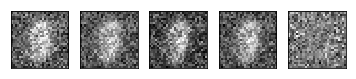

epoch 000, loss 0.65(gen) 0.92(disc)


KeyboardInterrupt: 

In [13]:
import tqdm

for epoch in range(101):
    # Generator loss, Discriminator loss
    metrics = [0, 0]
    
    for image, _ in tqdm.tqdm_notebook(data_loader, leave=False):
        loss1, loss2 = train((image - 127.5) / 127.5)
        metrics[0] += loss1 / len(data_loader)
        metrics[1] += loss2 / len(data_loader)  
    
    if epoch % 25 == 0:
        epoch = str(epoch).zfill(3)
        visualize()
        print("epoch {0}, loss {1:.2f}(gen) {2:.2f}(disc)".format(epoch, *metrics))  